**<center><p style="font-size:40px;">Classification des IRM cérébrales pour la détection de la démence</p></center>**

**Présentation du projet**


>Ce projet vise à classifier des images d'IRM cérébrales en différentes catégories en fonction de la présence et du degré de démence (un syndrome qui désigne une dégradation progressive des fonctions cognitives, affectant la mémoire et le raisonnement).

**Objectif**

>L'objectif principal de ce travail est de développer et d'évaluer plusieurs modèles d'apprentissage profond, notamment un réseau de neurones convolutif (CNN) personnalisé, ainsi que des modèles pré-entraînés tels que VGG et GoogleNet (InceptionV3), afin de classer avec précision les images cérébrales dans leurs catégories respectives : NonDemented, VeryMildDemented, MildDemented, et ModerateDemented.

>Ce projet vise à contribuer à la détection précoce de la démence, ce qui pourrait grandement aider au diagnostic médical et à la prise en charge des patients.

**Approche**

>Prétraitement des données (des images IRM).

>Implémentation des modèles.

>Évaluation : Comparaison des performances des modèles à l’aide de métriques.


### Importation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.layers import Concatenate
import tensorflow as tf


### **Visualisation de la distribution des classes :**

In [8]:
path = r"C:\Users\skouz\OneDrive\Desktop\atelier\Alzheimer_s Dataset\data"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

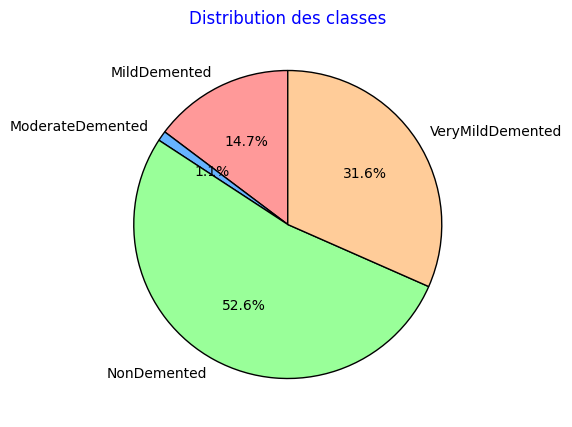

In [9]:
class_counts = {}
for cls in classes:
    class_path = os.path.join(path, cls)
    class_counts[cls] = len(os.listdir(class_path))

plt.figure(figsize=(5, 5)) 
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct='%1.1f%%',  
    startangle=90, 
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],  
    wedgeprops={'edgecolor': 'black'},
     
)
plt.title('Distribution des classes',color='blue')
plt.show()

>  le déséquilibre des classes n'est pas si critique qu'il nécessite une intervention via la data augmentation.

### **Affichage d'échantillons d'images :**

In [93]:
#Analyse des dimensions des images :
shapes = {}
for cls in classes:
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    shapes[cls] = img.size
    print(f"{cls}: {shapes[cls]}")

MildDemented: (176, 208)
ModerateDemented: (176, 208)
NonDemented: (176, 208)
VeryMildDemented: (176, 208)


> Toutes les classes ont les mêmes dimensions d’images (176, 208)

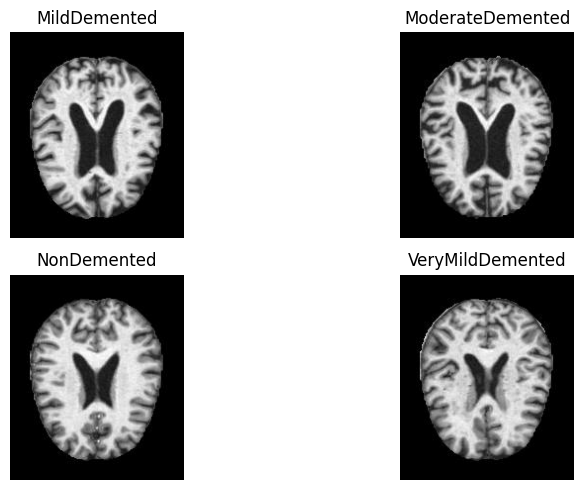

In [94]:
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img,cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

>**Cerveau non dement :** L'image IRM montre une structure cérébrale normale. Les régions du cerveau apparaissent intactes et bien définies.

>**Cerveau dement :** L'image IRM montre une atrophie cérébrale significative avec un rétrécissement marqué des régions cérébrales et un élargissement notable des ventricules(zones sombres).

### **Transformation et comparaison**

In [95]:
def select_random_image(dataset_path):
    all_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    return random.choice(all_images)

def rotate_image(image, degrees=45):
    return image.rotate(degrees, expand=True)

def add_random_noise(image, intensity):
    img_array = np.array(image)
    noise = np.random.normal(0, intensity*255, img_array.shape)
    noisy_array = img_array + noise
    return Image.fromarray(np.clip(noisy_array, 0, 255).astype(np.uint8))

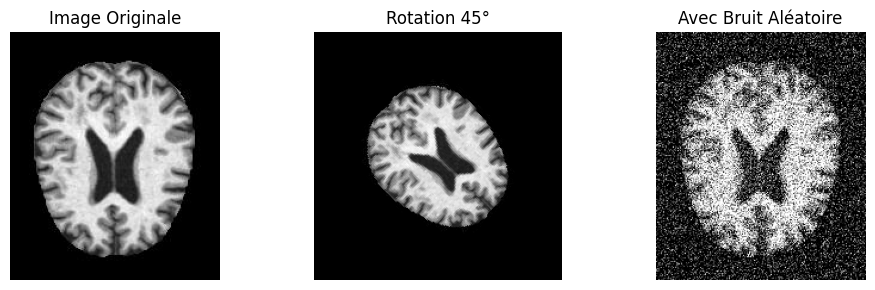

In [96]:
random_image_path = select_random_image(path)
original_image = Image.open(random_image_path)
rotated_image = rotate_image(original_image)
noisy_image = add_random_noise(original_image,0.3)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Image Originale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title('Rotation 45°')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Avec Bruit Aléatoire')
plt.axis('off')
plt.tight_layout()
plt.show()

>   Les IRM cérébrales sont des données médicales sensibles. Toute transformation risque d'altérer des caractéristiques essentielles au diagnostic de la démence. La "data augmentation" pourrait introduire des artefacts ou masquer des signaux subtils, affectant ainsi l'apprentissage du modèle.

### **Préparation des données**

In [44]:
# Load and preprocess images
def load_images(path, classes, img_size=(128, 128)):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open image and convert to grayscale if needed
                img = Image.open(img_path).convert('L')
                # Resize image
                img = img.resize(img_size)
                # Convert to numpy array
                img_array = np.array(img)
                # Normalize to 0-1 range (but not standard normalization)
                img_array = img_array / 255.0
                # Add channel dimension
                img_array = np.expand_dims(img_array, axis=-1)
                
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

In [45]:
# Load all images
X, y = load_images(path, classes)

# Convert labels to one-hot encoding
y_onehot = to_categorical(y, num_classes=len(classes))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y)

### **Création des modèles**

**CNN**

In [46]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**VGG pré-entraîné**

In [65]:
def create_vgg_model(input_shape, num_classes):
    # Convert grayscale to RGB by repeating the channel
    input_tensor = Input(shape=input_shape)
    x = Concatenate()([input_tensor, input_tensor, input_tensor])  # Convert to 3 channels
    
    # Load VGG16
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer=Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

**GoogleNet (InceptionV3) pré-entraîné**

In [73]:
def create_inception_model(input_shape, num_classes):
    # Input layer
    input_tensor = Input(shape=input_shape)
    
    # Convert grayscale to RGB using one of these methods:
    
    # Méthode 1: Répétition des canaux avec Lambda
    x = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_tensor)
    
    # Méthode alternative 2: Convolution 1x1
    # x = Conv2D(3, (1, 1), padding='same')(input_tensor)
    
    # Load InceptionV3 with pre-trained weights
    base_model = InceptionV3(weights='imagenet',
                           include_top=False,
                           input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

### **Entraînement des modèles**

In [59]:
def train_and_evaluate(model, X_train, y_train, epochs=10):
    # Lists to store metrics
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    all_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    # Convert one-hot back to labels for some metrics
    y_train_labels = np.argmax(y_train, axis=1)
    
    # For each epoch, we'll use a different validation split
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # Create a new validation split for this epoch
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=epoch, stratify=y_train_labels)
        
        # Train the model
        history = model.fit(X_tr, y_tr, 
                           validation_data=(X_val, y_val),
                           epochs=1, 
                           batch_size=32,
                           verbose=1)
        
        # Store training and validation metrics
        train_acc_history.append(history.history['accuracy'][0])
        val_acc_history.append(history.history['val_accuracy'][0])
        train_loss_history.append(history.history['loss'][0])
        val_loss_history.append(history.history['val_loss'][0])
        
        # Predict on validation set and calculate metrics
        y_val_pred = model.predict(X_val)
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)
        
        # Calculate metrics
        all_metrics['accuracy'].append(accuracy_score(y_val_labels, y_val_pred_labels))
        all_metrics['precision'].append(precision_score(y_val_labels, y_val_pred_labels, average='weighted'))
        all_metrics['recall'].append(recall_score(y_val_labels, y_val_pred_labels, average='weighted'))
        all_metrics['f1'].append(f1_score(y_val_labels, y_val_pred_labels, average='weighted'))
        
        # AUC needs probability estimates
        try:
            auc = roc_auc_score(y_val, y_val_pred, multi_class='ovr')
            all_metrics['auc'].append(auc)
        except:
            all_metrics['auc'].append(0.5)  # If calculation fails
    
    # Create figure with two subplots
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_acc_history, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy')
    plt.title(f'Accuracy - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_loss_history, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss_history, label='Validation Loss')
    plt.title(f'Loss - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return all_metrics

Training CNN model...

Epoch 1/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.4865 - loss: 1.0901 - val_accuracy: 0.5663 - val_loss: 0.9164
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5715 - loss: 0.9211 - val_accuracy: 0.5786 - val_loss: 0.9280
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5838 - loss: 0.8858 - val_accuracy: 0.6434 - val_loss: 0.7485
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.6717 - loss: 0.7453 - val_accuracy: 0.6845 - val_loss: 0.6842
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.6933 - loss: 0.6609 - val_accuracy: 0.7708 - val_loss: 0.5645
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.7718 - loss: 0.5436 - val_accuracy: 0.8458 - val_loss: 0.3796
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8297 - loss: 0.4121 - val_accuracy: 0.8993 - val_loss: 0.2629
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8550 - loss: 0.3439 - val_accuracy: 0.9466 - val_loss: 0.1694
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9047 - loss: 0.2395 - val_accuracy: 0.9723 - val_loss: 0.1202
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9268 - loss: 0.1926 - val_accuracy: 0.9620 - val_loss: 0.1014
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


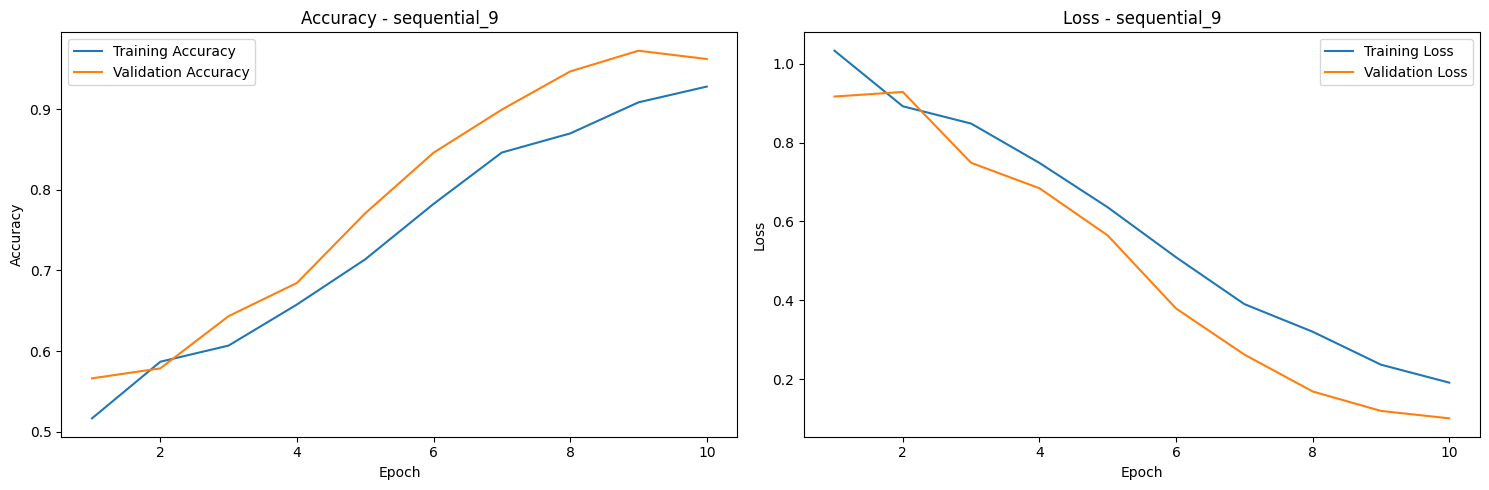

In [60]:
# Get input shape
input_shape = X_train[0].shape
# Create and train CNN model
print("Training CNN model...")
cnn_model = create_cnn_model(input_shape, len(classes))
cnn_model._name = "CNN"
cnn_metrics = train_and_evaluate(cnn_model, X_train, y_train)


Training VGG16 model...

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 654ms/step - accuracy: 0.4616 - loss: 1.3714 - val_accuracy: 0.5570 - val_loss: 0.9137
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 528ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 655ms/step - accuracy: 0.5352 - loss: 0.9789 - val_accuracy: 0.5663 - val_loss: 0.8997
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 635ms/step - accuracy: 0.5281 - loss: 0.9408 - val_accuracy: 0.5817 - val_loss: 0.8335
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 491ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 635ms/step - accuracy: 0.5574 - loss: 0.9070 - val_accuracy: 0.5673 - val_loss: 0.8516
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 492ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 632ms/step - accuracy: 0.5430 - loss: 0.9155 - val_accuracy: 0.5868 - val_loss: 0.8633
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 632ms/step - accuracy: 0.5526 - loss: 0.8941 - val_accuracy: 0.5992 - val_loss: 0.7972
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 636ms/step - accuracy: 0.5963 - loss: 0.8431 - val_accuracy: 0.6218 - val_loss: 0.7903
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 631ms/step - accuracy: 0.5854 - loss: 0.8424 - val_accuracy: 0.6413 - val_loss: 0.7798
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 487ms/step

Epoch 9/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 633ms/step - accuracy: 0.5991 - loss: 0.8262 - val_accuracy: 0.6351 - val_loss: 0.7614
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step

Epoch 10/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 633ms/step - accuracy: 0.6108 - loss: 0.8268 - val_accuracy: 0.6763 - val_loss: 0.7376
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 487ms/step


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


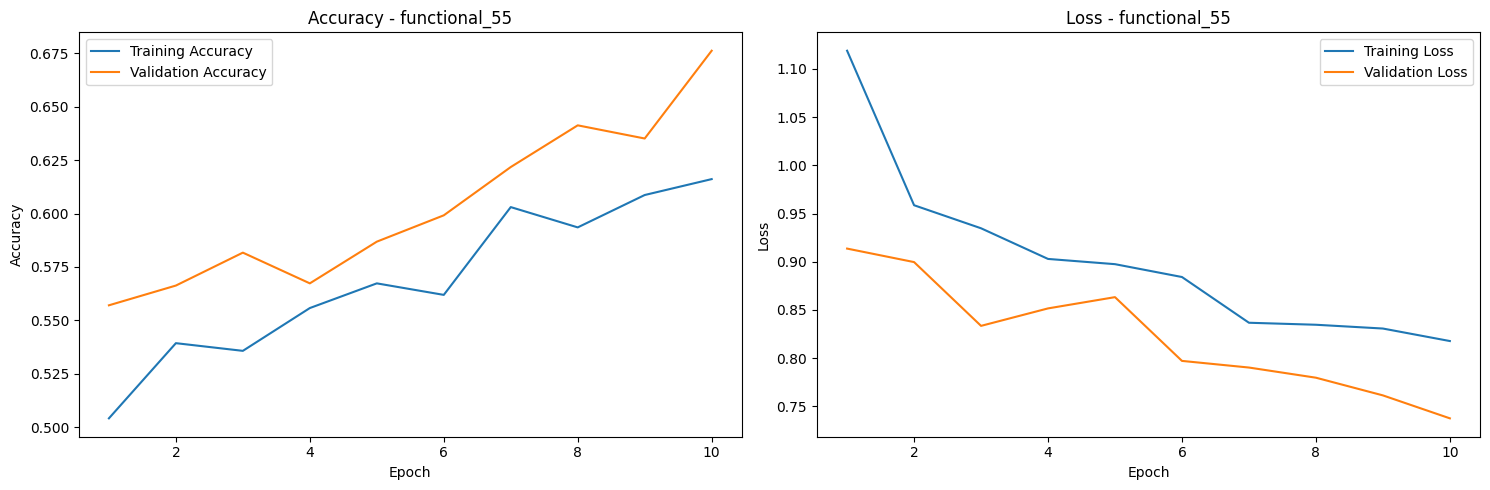

In [70]:
print("\nTraining VGG16 model...")
vgg_model = create_vgg_model(input_shape, len(classes))
vgg_model._name = "VGG16"
vgg_metrics = train_and_evaluate(vgg_model, X_train, y_train)


Training InceptionV3 model...


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.4695 - loss: 6.1183 - val_accuracy: 0.5529 - val_loss: 0.9498
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.5502 - loss: 0.9789 - val_accuracy: 0.5910 - val_loss: 0.8779
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5550 - loss: 0.9299 - val_accuracy: 0.5940 - val_loss: 0.8683
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.5349 - loss: 0.9641 - val_accuracy: 0.5940 - val_loss: 0.8539
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5488 - loss: 0.9287 - val_accuracy: 0.5755 - val_loss: 0.9146
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5614 - loss: 0.9270 - val_accuracy: 0.5272 - val_loss: 0.8602
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5362 - loss: 0.9386 - val_accuracy: 0.5868 - val_loss: 0.8295
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5748 - loss: 0.9148 - val_accuracy: 0.6218 - val_loss: 0.8113
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

Epoch 9/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5667 - loss: 0.9028 - val_accuracy: 0.5868 - val_loss: 0.8277
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

Epoch 10/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5640 - loss: 0.9048 - val_accuracy: 0.6197 - val_loss: 0.8827
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


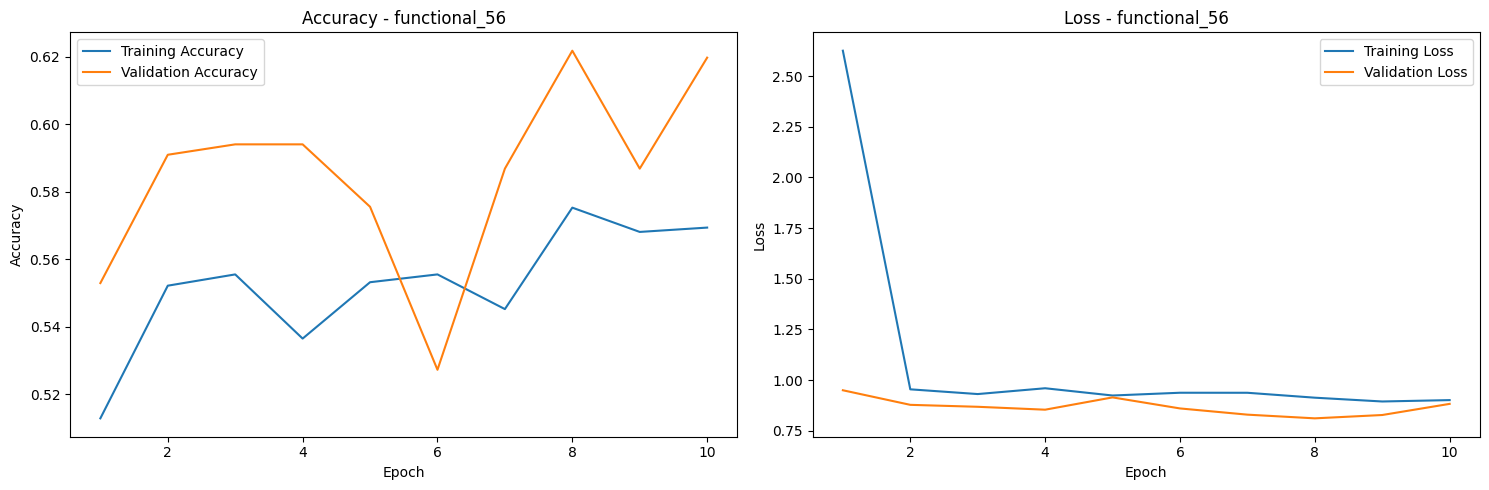

In [76]:
print("\nTraining InceptionV3 model...")
inception_model = create_inception_model(input_shape, len(classes))
inception_model._name = "InceptionV3"
inception_metrics = train_and_evaluate(inception_model, X_train, y_train)

### **Comparaison des modèles lors de la validation**

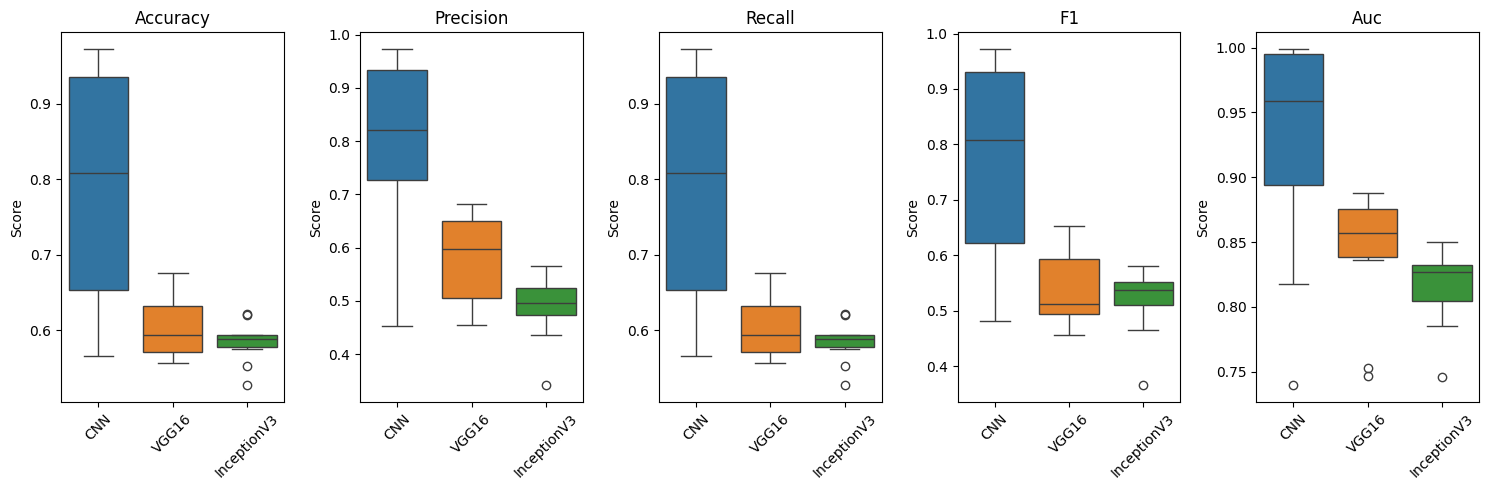

In [82]:
# Create boxplots for validation metrics comparison
metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics_names):
    plt.subplot(1, 5, i+1)
    data = {
        'CNN': cnn_metrics[metric],
        'VGG16': vgg_metrics[metric],
        'InceptionV3': inception_metrics[metric]
    }
    sns.boxplot(data=pd.DataFrame(data))
    plt.title(metric.capitalize())
    plt.ylabel('Score')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### **Test et comparaison**

In [83]:
def evaluate_on_test(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    
    metrics = {
        'accuracy': accuracy_score(y_test_labels, y_test_pred_labels),
        'precision': precision_score(y_test_labels, y_test_pred_labels, average='weighted'),
        'recall': recall_score(y_test_labels, y_test_pred_labels, average='weighted'),
        'f1': f1_score(y_test_labels, y_test_pred_labels, average='weighted')
    }
    
    try:
        metrics['auc'] = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    except:
        metrics['auc'] = 0.5
    
    return metrics

In [84]:
# Evaluate all models on test set
test_results = []

models = {
    'CNN': cnn_model,
    'VGG16': vgg_model,
    'InceptionV3': inception_model
}

for model_name, model in models.items():
    metrics = evaluate_on_test(model, X_test, y_test)
    metrics['model'] = model_name
    test_results.append(metrics)

# Create DataFrame with test results
test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'auc']]

print("\nTest Results:")
print(test_results_df)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step

Test Results:
         model  accuracy  precision    recall        f1       auc
0          CNN  0.945768   0.948134  0.945768  0.944388  0.994647
1        VGG16  0.636812   0.617708  0.636812  0.608620  0.864457
2  InceptionV3  0.597371   0.546145  0.597371  0.560182  0.812391


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Sauveguarde et importe du modele**

In [99]:
# Sauvegarde du modèle
def save_model_modern(model, model_name, save_dir='saved_models'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    save_model(model, model_path)
    print(f"Modèle sauvegardé (format moderne): {model_path}")
    return model_path

model_path = save_model_modern(cnn_model, 'alzheimer_classifier')

Modèle sauvegardé (format moderne): saved_models\alzheimer_classifier.keras


In [104]:
# Charger le modèle
loaded_model = load_saved_model(model_path)

Modèle chargé depuis : saved_models\alzheimer_classifier.keras


In [108]:
def predict_with_random_image(model, dataset_path, class_names):
    """
    Version corrigée qui s'adapte automatiquement à la shape d'entrée du modèle
    """
    # Sélectionner une image aléatoire
    image_path = select_random_image(dataset_path)
    
    # Trouver la classe réelle
    true_class = os.path.basename(os.path.dirname(image_path))
    
    # Déterminer la taille d'entrée attendue par le modèle
    if len(model.input_shape) == 4:
        img_size = model.input_shape[1:3]  # (height, width)
        target_channels = model.input_shape[3]
    else:
        img_size = model.input_shape[1:]  # Cas particulier
        target_channels = 1
    
    # Charger et prétraiter l'image
    img = Image.open(image_path).convert('L').resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)  # (h, w, 1)
    
    # Adapter les canaux si nécessaire
    if target_channels == 3:
        img_array = np.repeat(img_array, 3, axis=-1)  # (h, w, 3)
    elif target_channels == 1:
        pass  # Déjà au bon format
    else:
        raise ValueError(f"Format de canal non supporté: {target_channels}")
    
    # Ajouter dimension batch (1, h, w, c)
    img_array = np.expand_dims(img_array, axis=0)
    
    try:
        # Faire la prédiction
        pred_proba = model.predict(img_array)
        pred_class_idx = np.argmax(pred_proba)
        pred_class = class_names[pred_class_idx]
        confidence = pred_proba[0][pred_class_idx]
        
        # Afficher les résultats
        plt.figure(figsize=(12, 5))
        
        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {os.path.basename(image_path)}\nClasse réelle: {true_class}")
        plt.axis('off')
        
        # Probabilités
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_names, pred_proba[0])
        bars[pred_class_idx].set_color('red')
        plt.title('Probabilités de prédiction')
        plt.xlabel('Confiance')
        plt.xlim([0, 1])
        
        plt.suptitle(f"Prédiction: {pred_class} (Confiance: {confidence:.2%})")
        plt.tight_layout()
        plt.show()
        
        print("\nDétails de prédiction:")
        for i, prob in enumerate(pred_proba[0]):
            print(f"{class_names[i]}: {prob:.2%}")
        
        return {
            'image_path': image_path,
            'true_class': true_class,
            'predicted_class': pred_class,
            'confidence': confidence,
            'probabilities': pred_proba[0].tolist()
        }
        
    except Exception as e:
        print(f"Erreur lors de la prédiction: {str(e)}")
        print(f"Shape de l'image fournie: {img_array.shape}")
        print(f"Shape attendue par le modèle: {model.input_shape}")
        return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


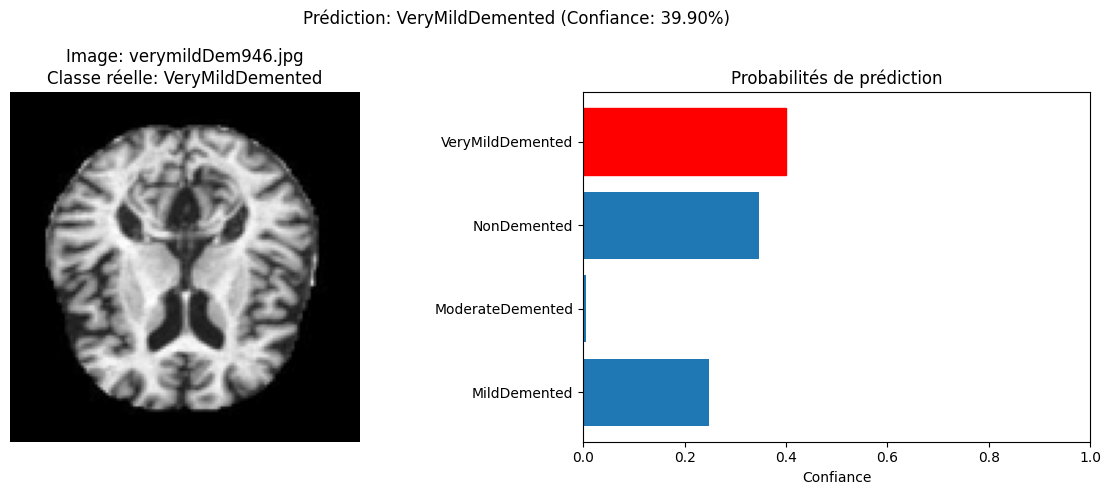


Détails de prédiction:
MildDemented: 24.89%
ModerateDemented: 0.60%
NonDemented: 34.61%
VeryMildDemented: 39.90%


In [109]:
# Faire une prédiction
result = predict_with_random_image(model, path, classes)